In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1.销售统计数据分析

In [49]:
df = pd.read_excel('./Dataset/乳胶枕2018数据.xlsx', sheet_name = '数据')
df.columns = df.columns.str.replace('\n', '')
data_cleaned =df.loc[:, ~df.T.duplicated(keep='first')]
data_cleaned = data_cleaned.drop(columns=['数据类型','备注', '星期'])
# Display the cleaned dataframe's columns to verify
data_cleaned.columns

Index(['日期', '总下单金额', '总支付金额', 'PC端支付金额', '无线端支付金额', '总下单件数', '总下单买家数',
       '总支付件数', 'PC端支付件数', '无线端支付件数', '总支付买家数', 'PC端支付买家数', '无线端支付买家数', '总转化',
       'PC总转化', '无线转化', '总访客数', 'PC端访客数', '无线端访客数', 'PC端平均停留时间', '无线端平均停留时间',
       'PC端日均跳出率', '无线端日均跳出率', '加购人数', '商品收藏人数', '总加购件数', 'PC端加购件数', '无线端加购件数',
       '未付款金额', '未付款占比', '未支付买家数', '未支付占比', '人均件数', '真实总支付金额', '无线真实支付金额',
       '真实支付件数', 'PC端真实支付件数', '无线端真实支付件数', '真实下单买家数', '真实支付买家数', '无线端真实支付买家数',
       '真实人均件数', 'PC端真实人均件数', '无线端真实人均件数', '真实总转化', 'PC真实转化', '无线真实转化',
       '真实总客单价', 'PC端真实客单价', '无线端真实客单价', '人均加购件数', '总加购率', '总收藏率', '总加收藏人数',
       'PC端收藏人数', '过滤总转化', '业务加购人数', '业务加购件数', '业务收藏人数', '真实总流量', '真实无线流量',
       '真实加购人数', '真实加购件数', '真实收藏人数', '真实加购率', '真实收藏率', '真实人均加购件数', '过滤加购总转化',
       '过滤加购无线转化', '下单转化率'],
      dtype='object')

存在一些数据重复列，可能是数据收集时存在的问题。如 【PC真实转化, 过滤PC转化, 过滤加购PC转化】三者为同一数据，无法理解。

In [50]:
# 用于存储已经找到的重复列，避免重复输出
checked_columns = set()
duplicates = []

# 遍历每一列，比较每一列是否与其他列相同
for i, col in enumerate(df.columns):
    if col not in checked_columns:  # 如果该列已经被处理过，则跳过
        duplicate_group = [col]  # 初始化一个新的重复列组
        for j in range(i + 1, len(df.columns)):
            if df[col].equals(df[df.columns[j]]):  # 检查两列是否相等
                duplicate_group.append(df.columns[j])
                checked_columns.add(df.columns[j])  # 标记已经检查的列
        if len(duplicate_group) > 1:  # 如果找到重复列，保存
            duplicates.append(duplicate_group)
        checked_columns.add(col)  # 标记已经检查的列

# 输出每组重复的列
for group in duplicates:
    print(f"Duplicate columns: {', '.join(group)}")
print(f"总共剔除的列数：{df.T.duplicated().sum()}")

Duplicate columns: PC端支付金额, PC真实支付金额
Duplicate columns: PC端支付买家数, PC端真实支付买家数
Duplicate columns: PC端访客数, 真实PC流量
Duplicate columns: PC真实转化, 过滤PC转化, 过滤加购PC转化
Duplicate columns: 无线真实转化, 过滤无线转化
Duplicate columns: 总加收藏人数, 无线端收藏人数
Duplicate columns: PC端收藏人数, 手淘首页
总共剔除的列数：8


In [51]:
#数据分类
pc_range = [col  for col in data_cleaned.columns if 'PC' in col]
mobile_range = [col for col in data_cleaned.columns if '无线' in col]
total_range = [col for col in data_cleaned.columns if col not in (pc_range + mobile_range)]
pc_data, mobile_data = data_cleaned[pc_range], data_cleaned[mobile_range]

### 1.1 PC端数据

In [52]:
pc_data = pc_data.dropna()
pc_data  = pc_data.drop(columns=['PC端收藏人数'])


#### 1.1.1 相关性分析

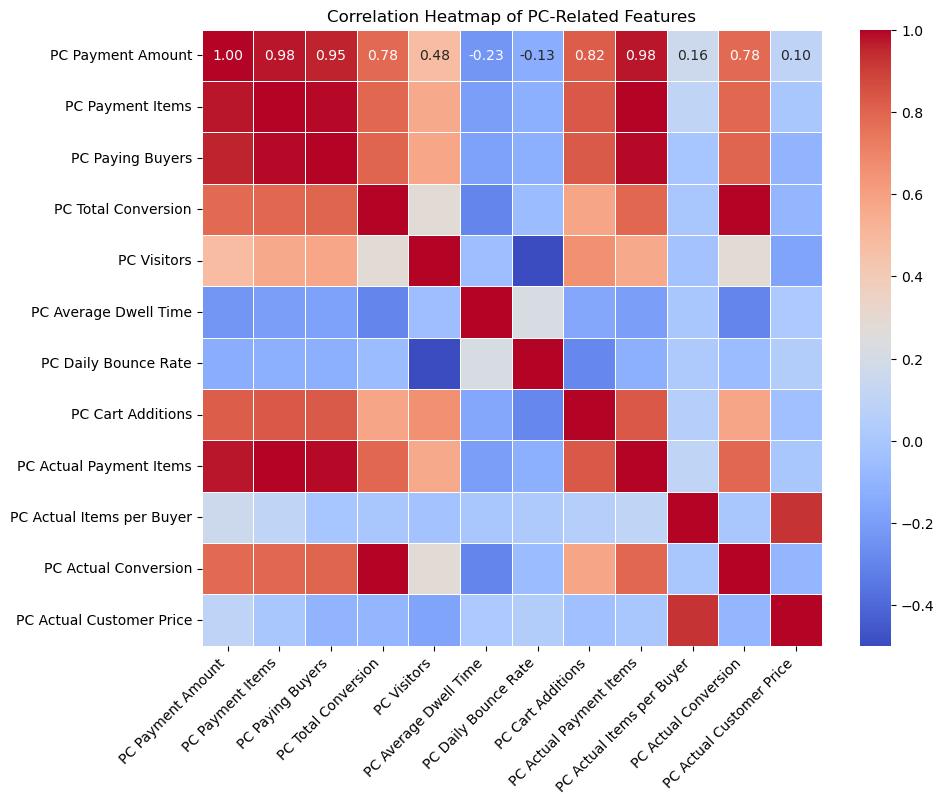

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'pc_data_cleaned' is your cleaned dataset of the 13 PC-related columns
# Dictionary for renaming the columns
rename_dict = {
    'PC端支付金额': 'PC Payment Amount',
    'PC端支付件数': 'PC Payment Items',
    'PC端支付买家数': 'PC Paying Buyers',
    'PC总转化': 'PC Total Conversion',
    'PC端访客数': 'PC Visitors',
    'PC端平均停留时间': 'PC Average Dwell Time',
    'PC端日均跳出率': 'PC Daily Bounce Rate',
    'PC端加购件数': 'PC Cart Additions',
    'PC端真实支付件数': 'PC Actual Payment Items',
    'PC端真实人均件数': 'PC Actual Items per Buyer',
    'PC真实转化': 'PC Actual Conversion',
    'PC端真实客单价': 'PC Actual Customer Price',
}

# Renaming the columns in the dataframe
pc_data = pc_data.rename(columns=rename_dict)


# Calculate the correlation matrix
correlation_matrix = pc_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap of PC-Related Features')
plt.show()

以上销售数据多为结论性统计指标，根据相关性热力图来看，具有强相关性的指标（corr>=0.8）本质上通过其他变量直接联系，类目接近（例如（PC支付件数，PC支付金额），（PC支付件数，PC真实支付件数）....），对我们的销售策略指导性低。对其采用因果分析容易导出伪因果关系。  
首先关注一组比较负相关数据，‘日均跳出率’（即在不做任何互动的情况下离开网站的用户比例）与 ‘访客数’相关系数-0.5左右，尝试研究二者之间是否有因果关系。

#### 1.1.2 Bounce Rate VS Visitors

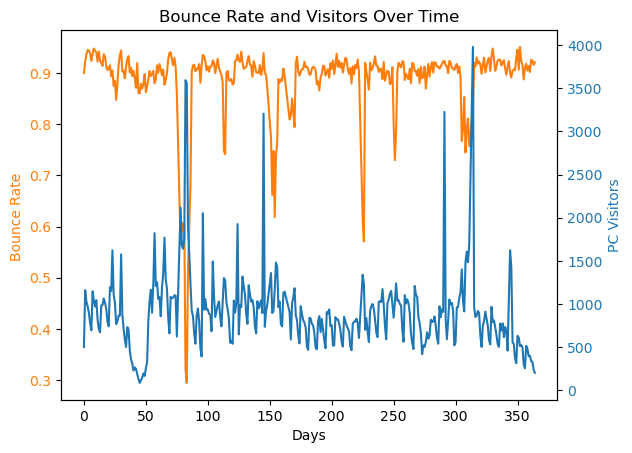

In [54]:
# 创建图像和第一个 Y 轴
fig, ax1 = plt.subplots()

# 绘制 bounce rate，左侧 Y 轴
color = 'tab:orange'
ax1.set_xlabel('Days')
ax1.set_ylabel('Bounce Rate ', color=color)
ax1.plot( pc_data['PC Daily Bounce Rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个 Y 轴，与第一个 Y 轴共享 X 轴
ax2 = ax1.twinx()  # 创建一个共享 X 轴的第二坐标轴

# 绘制 visitors，右侧 Y 轴
color = 'tab:blue'
ax2.set_ylabel('PC Visitors', color=color)
ax2.plot(pc_data['PC Visitors'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 显示图表
plt.title('Bounce Rate and Visitors Over Time')
plt.show()

对‘Bounce Rate’ 以及 ‘Visitors’两列特征尝试采用Granger**因果检验**，Granger 因果关系认为，如果一个变量 𝑋（Bounce Rate）能够帮助预测另一个变量 𝑌（Visitors），那么我们可以说 X Granger 引起了 𝑌。要注意的是，Granger 因果性是预测性因果关系表示 𝑋对𝑌的先行性和预测力，但不一定是实际的因果关系。

In [56]:
from statsmodels.tsa.stattools import adfuller

# 检查 bounce rate 是否平稳
result_bounce_rate = adfuller(pc_data['PC Daily Bounce Rate'])
print(f'ADF Statistic for Bounce Rate: {result_bounce_rate[0]}')
print(f'p-value for Bounce Rate: {result_bounce_rate[1]}')

# 检查 visitors 是否平稳
result_visitors = adfuller(pc_data['PC Visitors'])
print(f'ADF Statistic for Visitors: {result_visitors[0]}')
print(f'p-value for Visitors: {result_visitors[1]}')


ADF Statistic for Bounce Rate: -6.474105383837401
p-value for Bounce Rate: 1.3444574286943596e-08
ADF Statistic for Visitors: -5.445107395218879
p-value for Visitors: 2.721526868956212e-06


满足平稳性假设， P << 0.05

In [55]:
from statsmodels.tsa.stattools import grangercausalitytests

# 假设你的数据有两列 'Bounce Rate' 和 'Visitors'
# 按时间顺序排列，确保你有一个 DataFrame，名称为 data_cleaned

# 设置 maxlag，表示检验的滞后阶数
max_lag = 5

# 进行 Granger 因果检验，测试是否 Bounce Rate Granger 导致 Visitors
# 假设 data_cleaned 是你的数据，包含 'Bounce Rate' 和 'Visitors' 两列
granger_test_result = grangercausalitytests(pc_data[['PC Daily Bounce Rate', 'PC Visitors']], maxlag=max_lag)

# grangercausalitytests 将输出详细的检验结果，包括不同滞后阶数下的 F 检验结果。


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2735  , p=0.6013  , df_denom=350, df_num=1
ssr based chi2 test:   chi2=0.2758  , p=0.5995  , df=1
likelihood ratio test: chi2=0.2757  , p=0.5995  , df=1
parameter F test:         F=0.2735  , p=0.6013  , df_denom=350, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2018  , p=0.8174  , df_denom=347, df_num=2
ssr based chi2 test:   chi2=0.4093  , p=0.8149  , df=2
likelihood ratio test: chi2=0.4091  , p=0.8150  , df=2
parameter F test:         F=0.2018  , p=0.8174  , df_denom=347, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2982  , p=0.8267  , df_denom=344, df_num=3
ssr based chi2 test:   chi2=0.9127  , p=0.8224  , df=3
likelihood ratio test: chi2=0.9115  , p=0.8227  , df=3
parameter F test:         F=0.2982  , p=0.8267  , df_denom=344, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2907  , p=0.8840  

In [47]:
from statsmodels.tsa.stattools import grangercausalitytests

# 假设你的数据有两列 'Bounce Rate' 和 'Visitors'
# 按时间顺序排列，确保你有一个 DataFrame，名称为 data_cleaned

# 设置 maxlag，表示检验的滞后阶数
max_lag = 5

# 进行 Granger 因果检验，测试是否 Bounce Rate Granger 导致 Visitors
# 假设 data_cleaned 是你的数据，包含 'Bounce Rate' 和 'Visitors' 两列
granger_test_result = grangercausalitytests(pc_data[['PC Visitors', 'PC Daily Bounce Rate']], maxlag=max_lag)

# grangercausalitytests 将输出详细的检验结果，包括不同滞后阶数下的 F 检验结果。


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.3832 , p=0.0000  , df_denom=350, df_num=1
ssr based chi2 test:   chi2=20.5579 , p=0.0000  , df=1
likelihood ratio test: chi2=19.9815 , p=0.0000  , df=1
parameter F test:         F=20.3832 , p=0.0000  , df_denom=350, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9163  , p=0.0002  , df_denom=347, df_num=2
ssr based chi2 test:   chi2=18.0895 , p=0.0001  , df=2
likelihood ratio test: chi2=17.6401 , p=0.0001  , df=2
parameter F test:         F=8.9163  , p=0.0002  , df_denom=347, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0397  , p=0.0005  , df_denom=344, df_num=3
ssr based chi2 test:   chi2=18.4879 , p=0.0003  , df=3
likelihood ratio test: chi2=18.0175 , p=0.0004  , df=3
parameter F test:         F=6.0397  , p=0.0005  , df_denom=344, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5352  , p=0.0014  

经过两组检验我们发现 **Visitors 对 Bounce Rate 有显著的 Granger 因果关系**。每个滞后阶数下（lag 1 到 5）的 p 值都非常小，鉴于二者的负相关性，可能的业务解释是：  
高质量流量带来的影响：  
如果你的网站获得了更多的访客（尤其是高质量流量），那么更多的用户可能会对你的网站内容感兴趣，从而 降低跳出率。换句话说，更多的访问量可能意味着更多的用户参与度，进而减少直接离开网站的用户比例。  
访客分布与行为：  
更高的访客数可能是某些特定营销活动的结果，比如吸引了特定兴趣群体的用户。这些用户可能更愿意与网站内容互动，导致跳出率的下降。  
上述因果关系给了我们一些思路，为后续含有推广流量的分析提供了帮助。

In [65]:
from statsmodels.tsa.stattools import grangercausalitytests

# 假设你的数据有两列 'Bounce Rate' 和 'Visitors'
# 按时间顺序排列，确保你有一个 DataFrame，名称为 data_cleaned

# 设置 maxlag，表示检验的滞后阶数
max_lag = 5

# 进行 Granger 因果检验，测试是否 Bounce Rate Granger 导致 Visitors
# 假设 data_cleaned 是你的数据，包含 'Bounce Rate' 和 'Visitors' 两列
granger_test_result = grangercausalitytests(pc_data[[ 'PC Visitors','PC Cart Additions']], maxlag=max_lag)

# grangercausalitytests 将输出详细的检验结果，包括不同滞后阶数下的 F 检验结果。


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1604  , p=0.2821  , df_denom=350, df_num=1
ssr based chi2 test:   chi2=1.1703  , p=0.2793  , df=1
likelihood ratio test: chi2=1.1684  , p=0.2797  , df=1
parameter F test:         F=1.1604  , p=0.2821  , df_denom=350, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1550  , p=0.3163  , df_denom=347, df_num=2
ssr based chi2 test:   chi2=2.3433  , p=0.3098  , df=2
likelihood ratio test: chi2=2.3356  , p=0.3111  , df=2
parameter F test:         F=1.1550  , p=0.3163  , df_denom=347, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1777  , p=0.0904  , df_denom=344, df_num=3
ssr based chi2 test:   chi2=6.6660  , p=0.0833  , df=3
likelihood ratio test: chi2=6.6035  , p=0.0857  , df=3
parameter F test:         F=2.1777  , p=0.0904  , df_denom=344, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8345  , p=0.1217  

#### 1.1.3 Cart addition  & Visitors
此外，加购数量、访客数、转换率与销售数据(支付金额、支付件数、支付买家数)有较高的相关性,转换率的定义目前难以明确，在剔除重复数据时转化相关的数据也均为重复值，暂时无法明确分析。从商业的角度，尝试看看加购数量是否与支付数据有因果关系

In [72]:
# 定义函数来批量进行 Granger 因果检验
def batch_granger_causality(df, causal_col, col_range, maxlag=5):
    results = {}
    # 遍历所有列的两两组合
    for col in col_range:
        try:
            test_result = grangercausalitytests(df[[causal_col, col]], maxlag=maxlag, verbose=False)
            # 获取最低的 p-value 以及对应的滞后阶数
            min_p_value = min([test[0]['ssr_chi2test'][1] for test in test_result.values()])
            # 存储结果
            results[(causal_col, col)] = min_p_value
        except:
            # 如果出现错误（如数据不平稳），可以跳过该对特征
            results[(causal_col, col)] = None
    return results

# 假设 df 是你的 DataFrame
# 批量处理每对列的因果关系，maxlag 表示检验的最大滞后阶数
causality_results = batch_granger_causality(pc_data,'PC Cart Additions',['PC Payment Amount', 'PC Payment Items', 'PC Paying Buyers'], maxlag=5)

# 打印具有显著因果关系的结果
significant_results = {key: value for key, value in causality_results.items() if value and value < 0.05}
for key, value in significant_results.items():
    print(f"{key[0]} Granger causes {key[1]} with p-value: {value}")

PC Cart Additions Granger causes PC Payment Amount with p-value: 6.920122443669192e-46
PC Cart Additions Granger causes PC Payment Items with p-value: 8.337553989918165e-56
PC Cart Additions Granger causes PC Paying Buyers with p-value: 2.368724866989824e-53


d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [73]:
# 定义函数来批量进行 Granger 因果检验
def batch_granger_causality(df, causal_col, col_range, maxlag=5):
    results = {}
    # 遍历所有列的两两组合
    for col in col_range:
        try:
            test_result = grangercausalitytests(df[[causal_col, col]], maxlag=maxlag, verbose=False)
            # 获取最低的 p-value 以及对应的滞后阶数
            min_p_value = min([test[0]['ssr_chi2test'][1] for test in test_result.values()])
            # 存储结果
            results[(causal_col, col)] = min_p_value
        except:
            # 如果出现错误（如数据不平稳），可以跳过该对特征
            results[(causal_col, col)] = None
    return results

# 假设 df 是你的 DataFrame
# 批量处理每对列的因果关系，maxlag 表示检验的最大滞后阶数
causality_results = batch_granger_causality(pc_data,'PC Visitors',['PC Payment Amount', 'PC Payment Items', 'PC Paying Buyers', 'PC Cart Additions'], maxlag=5)

# 打印具有显著因果关系的结果
significant_results = {key: value for key, value in causality_results.items() if value and value < 0.05}
for key, value in significant_results.items():
    print(f"{key[0]} Granger causes {key[1]} with p-value: {value}")

PC Visitors Granger causes PC Payment Amount with p-value: 1.2154045337641013e-05
PC Visitors Granger causes PC Payment Items with p-value: 7.677657836035051e-10
PC Visitors Granger causes PC Paying Buyers with p-value: 9.083454165361059e-11


d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


值得注意的是，加购数、访客数都对最终的销售数据有显著的因果关系，而二者似乎没有直接的因果联系。有多种解释的可能：  
- 二者相互独立  
- 二者存在间接因果关系，可以在第二部分考虑结构方程分析中介变量
- 二者存在非线性复杂关系 

## 2.推广数据

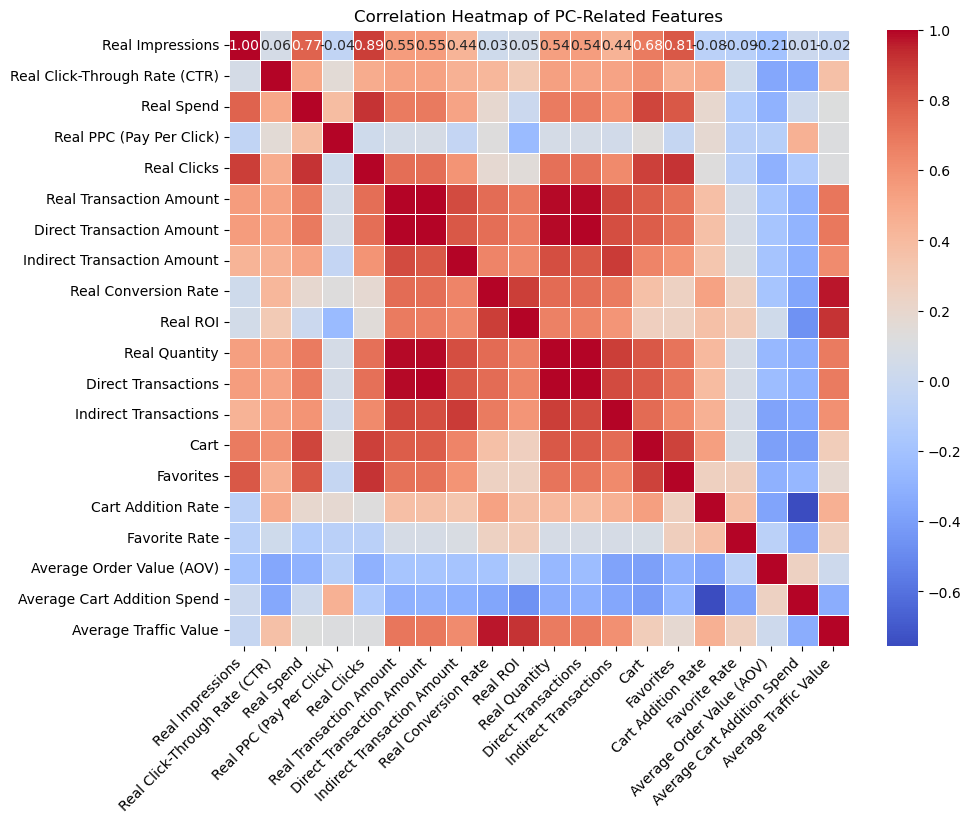

In [64]:
df_promotion = pd.read_excel('./Dataset/乳胶枕2018数据.xlsx', sheet_name = '推广数据').dropna()
df_promotion = df_promotion.drop(columns=['日期', '星期'])
# Calculate the correlation matrix
rename_dict = {
    '真实展现': 'Real Impressions',
    '真实点击率': 'Real Click-Through Rate (CTR)',
    '真实花费': 'Real Spend',
    '真实PPC': 'Real PPC (Pay Per Click)',
    '真实点击': 'Real Clicks',
    '真实成交金额': 'Real Transaction Amount',
    '直接成交金额': 'Direct Transaction Amount',
    '间接成交金额': 'Indirect Transaction Amount',
    '真实转化率': 'Real Conversion Rate',
    '真实ROI': 'Real ROI',
    '真实数量': 'Real Quantity',
    '直接成交笔数': 'Direct Transactions',
    '间接成交笔数': 'Indirect Transactions',
    '购物车': 'Cart',
    '收藏': 'Favorites',
    '加购率': 'Cart Addition Rate',
    '收藏率': 'Favorite Rate',
    '客单价': 'Average Order Value (AOV)',
    '平均加购花费': 'Average Cart Addition Spend',
    '平均流量价值': 'Average Traffic Value'
}

df_promotion = df_promotion.rename(columns=rename_dict)


correlation_matrix = df_promotion.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap of PC-Related Features')
plt.show()